In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [28]:
# ----------------------------
# 1. DATA PREPROCESSING FUNCTIONS (Same as before)
# ----------------------------
def preprocess_image(img, target_size=(224, 224)):
    img = cv2.resize(img, target_size)
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    closed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    mask = cv2.threshold(closed, 10, 255, cv2.THRESH_BINARY_INV)[1].astype(np.uint8)
    inpainted = cv2.inpaint(img, mask, 1, cv2.INPAINT_TELEA)
    norm_img = inpainted.astype("float32") / 255.0
    return norm_img


# ----------------------------
# 1. DATA PREPROCESSING FUNCTIONS
# ----------------------------

# Custom transform for ImageFolder that uses our preprocess function.
def custom_transform(x):
    # x is a PIL Image in RGB.
    # Convert to numpy array and then to BGR for OpenCV
    x = np.array(x)
    x = cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
    processed = preprocess_image(x, target_size=(299,299))
    # Convert processed image (H, W, C) to tensor with shape (C, H, W)
    processed = np.transpose(processed, (2, 0, 1))
    return torch.tensor(processed, dtype=torch.float32)

# ----------------------------
# 2. MODEL BUILDING
# ----------------------------
class XceptionModel(nn.Module):
    def __init__(self, num_classes):
        super(XceptionModel, self).__init__()
        # Load the pretrained Xception model from timm
        self.model = timm.create_model("xception", pretrained=True)
        in_features = self.model.fc.in_features  # Get size of final layer input
        # Replace the fully connected head with a custom head:
        # Example: a two-layer FC with ReLU, Dropout and final output layer.
        self.model.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)
# ----------------------------
# 3. HELPER FUNCTIONS FOR FC WEIGHTS HANDLING
# ----------------------------
def get_fc_layers_info(model):
    """
    Extract information for each fully-connected (nn.Linear) layer in the custom head.
    Returns a list of dictionaries.
    """
    fc_info = []
    # Assuming our custom head is in model.model.fc which is a Sequential.
    for layer in model.model.fc:
        if isinstance(layer, nn.Linear):
            weight_shape = tuple(layer.weight.size())  # (out_features, in_features)
            bias_shape = tuple(layer.bias.size())       # (out_features,)
            num_params = np.prod(weight_shape) + np.prod(bias_shape)
            fc_info.append({
                'layer': layer,
                'weight_shape': weight_shape,
                'bias_shape': bias_shape,
                'num_params': int(num_params)
            })
    return fc_info

def flatten_fc_weights(fc_info):
    """
    Flatten the weights and biases of FC layers into a single 1D numpy array.
    """
    params = []
    for info in fc_info:
        layer = info['layer']
        weight = layer.weight.data.cpu().numpy().flatten()
        bias = layer.bias.data.cpu().numpy().flatten()
        params.append(weight)
        params.append(bias)
    return np.concatenate(params)

def set_fc_weights_from_vector(model, fc_info, vector):
    """
    Set the weights and biases of the FC layers from a flattened vector.
    """
    idx = 0
    for info in fc_info:
        layer = info['layer']
        weight_num = np.prod(info['weight_shape'])
        bias_num = np.prod(info['bias_shape'])
        weight = vector[idx: idx + weight_num].reshape(info['weight_shape'])
        idx += weight_num
        bias = vector[idx: idx + bias_num].reshape(info['bias_shape'])
        idx += bias_num
        layer.weight.data = torch.tensor(weight, dtype=torch.float32, device=layer.weight.data.device)
        layer.bias.data = torch.tensor(bias, dtype=torch.float32, device=layer.bias.data.device)

# ----------------------------
# 4. ABC OPTIMIZER FOR FC INITIALIZATION
# ----------------------------
class ABCOptimizer:
    def __init__(self, objective_func, D, population_size=40, max_cycles=50, limit=20, d_selection=0.001, init_bound=0.1):
        """
        objective_func: function to minimize (e.g., cross-entropy loss on a mini-batch)
        D: Dimensionality of the search space (total number of FC parameters)
        population_size: Number of candidate solutions (bees)
        max_cycles: Maximum number of iterations (cycles)
        limit: Trial limit before a candidate is abandoned
        d_selection: Fraction or number of parameters to update per iteration
        init_bound: Bound for candidate weight values
        """
        self.objective_func = objective_func
        self.D = D
        self.population_size = population_size
        self.max_cycles = max_cycles
        self.limit = limit
        self.d_selection = int(D * d_selection) if d_selection < 1 else int(d_selection)
        self.init_bound = init_bound

        # Initialize population uniformly in [-init_bound, init_bound]
        self.population = np.random.uniform(-self.init_bound, self.init_bound, (population_size, D))
        self.fitness = np.array([self.objective_func(candidate) for candidate in self.population])
        self.trial = np.zeros(population_size, dtype=int)
        best_idx = np.argmin(self.fitness)
        self.best_solution = self.population[best_idx].copy()
        self.best_fitness = self.fitness[best_idx]

    def optimize(self):
        for cycle in tqdm(range(self.max_cycles), desc="ABC Optimization", unit="cycle"):
            # Employed Bee Phase
            for i in range(self.population_size):
                candidate = self.population[i].copy()
                indices = np.random.choice(self.D, self.d_selection, replace=False)
                k = np.random.randint(0, self.population_size)
                while k == i:
                    k = np.random.randint(0, self.population_size)
                phi = np.random.uniform(-1, 1, size=self.d_selection)
                new_candidate = candidate.copy()
                new_candidate[indices] = candidate[indices] + phi * (candidate[indices] - self.population[k][indices])
                new_candidate = np.clip(new_candidate, -self.init_bound, self.init_bound)
                new_fitness = self.objective_func(new_candidate)
                if new_fitness < self.fitness[i]:
                    self.population[i] = new_candidate.copy()
                    self.fitness[i] = new_fitness
                    self.trial[i] = 0
                    if new_fitness < self.best_fitness:
                        self.best_fitness = new_fitness
                        self.best_solution = new_candidate.copy()
                else:
                    self.trial[i] += 1

            # Onlooker Bee Phase
            fitness_prob = 1.0 / (1.0 + self.fitness)
            fitness_prob = fitness_prob / np.sum(fitness_prob)
            for _ in range(self.population_size):
                i = np.random.choice(np.arange(self.population_size), p=fitness_prob)
                candidate = self.population[i].copy()
                indices = np.random.choice(self.D, self.d_selection, replace=False)
                k = np.random.randint(0, self.population_size)
                while k == i:
                    k = np.random.randint(0, self.population_size)
                phi = np.random.uniform(-1, 1, size=self.d_selection)
                new_candidate = candidate.copy()
                new_candidate[indices] = candidate[indices] + phi * (candidate[indices] - self.population[k][indices])
                new_candidate = np.clip(new_candidate, -self.init_bound, self.init_bound)
                new_fitness = self.objective_func(new_candidate)
                if new_fitness < self.fitness[i]:
                    self.population[i] = new_candidate.copy()
                    self.fitness[i] = new_fitness
                    self.trial[i] = 0
                    if new_fitness < self.best_fitness:
                        self.best_fitness = new_fitness
                        self.best_solution = new_candidate.copy()
                else:
                    self.trial[i] += 1

            # Scout Bee Phase
            for i in range(self.population_size):
                if self.trial[i] > self.limit:
                    self.population[i] = np.random.uniform(-self.init_bound, self.init_bound, self.D)
                    self.fitness[i] = self.objective_func(self.population[i])
                    self.trial[i] = 0
                    if self.fitness[i] < self.best_fitness:
                        self.best_fitness = self.fitness[i]
                        self.best_solution = self.population[i].copy()

            tqdm.write(f"Cycle {cycle+1}/{self.max_cycles}, best fitness: {self.best_fitness:.4f}")
        return self.best_solution

In [29]:
# ----------------------------
# 5. TRAINING CONFIGURATION & DATA LOADING
# ----------------------------
ROOT_DIR = "/kaggle/input/resized300sccaksekmelbccnvmeldermsekonly/resized"
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 1e-5
CHECKPOINT_PATH = "/kaggle/working/best_model_xception.pth"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use our custom transform in ImageFolder
data_transform = transforms.Compose([
    transforms.Lambda(custom_transform)
])

dataset = datasets.ImageFolder(ROOT_DIR, transform=data_transform)
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ----------------------------
# 6. MODEL INSTANTIATION
# ----------------------------
model = XceptionModel(num_classes=num_classes).to(DEVICE)
# ----------------------------
# 7. ABC INITIALIZATION OF FC LAYERS
# ----------------------------
fc_info = get_fc_layers_info(model)
# Compute total number of parameters in the FC layers
D_total = sum(info['num_params'] for info in fc_info)
print(f"Total FC parameters to optimize: {D_total}")

# Prepare a fixed mini-batch from training data for objective evaluation
model.eval()
x_batch, y_batch = next(iter(train_loader))
x_batch = x_batch.to(DEVICE)
y_batch = y_batch.to(DEVICE)
criterion = nn.CrossEntropyLoss()

def objective_func(candidate_vector):
    # Save original FC weights
    original_weights = [layer.weight.data.clone() for info in fc_info for layer in [info['layer']]]
    original_biases = [layer.bias.data.clone() for info in fc_info for layer in [info['layer']]]
    
    # Set candidate weights
    set_fc_weights_from_vector(model, fc_info, candidate_vector)
    
    # Evaluate loss on the mini-batch
    with torch.no_grad():
        outputs = model(x_batch)
        loss_val = criterion(outputs, y_batch).item()
    
    # Restore original weights
    idx = 0
    for info in fc_info:
        layer = info['layer']
        layer.weight.data = original_weights[idx]
        layer.bias.data = original_biases[idx]
        idx += 1
    
    return loss_val

# Run ABC optimization to obtain optimal initial weights for FC layers
abc_optimizer = ABCOptimizer(objective_func, D_total, population_size=40, max_cycles=50, limit=20, d_selection=0.001, init_bound=0.1)
optimal_vector = abc_optimizer.optimize()

# Set the optimized weights in the model's FC layers
set_fc_weights_from_vector(model, fc_info, optimal_vector)
print("Optimal initial weights have been set for the FC layers.")

# ----------------------------
# 8. TRAINING & EVALUATION
# ----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_train_acc = 0
metrics = []

for epoch in range(EPOCHS):
    model.train()
    train_loss, correct, total = 0, 0, 0
    train_preds, train_labels = [], []
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", unit="batch"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())
    
    train_acc = 100. * correct / total
    avg_train_loss = train_loss / total
    
    if train_acc > best_train_acc:
        best_train_acc = train_acc
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print("Checkpoint saved!")
    
    # Validation Step
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    
    avg_val_loss = val_loss / val_total
    val_acc = 100. * val_correct / val_total
    
    train_precision = precision_score(train_labels, train_preds, average='weighted')
    train_recall = recall_score(train_labels, train_preds, average='weighted')
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    
    val_precision = precision_score(val_labels, val_preds, average='weighted')
    val_recall = recall_score(val_labels, val_preds, average='weighted')
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    
    metrics.append([epoch+1, avg_train_loss, train_acc, train_precision, train_recall, train_f1,
                    avg_val_loss, val_acc, val_precision, val_recall, val_f1])
    
    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

# Save metrics to CSV
columns = ["Epoch", "Train Loss", "Train Accuracy", "Train Precision", "Train Recall", "Train F1-Score",
           "Val Loss", "Val Accuracy", "Val Precision", "Val Recall", "Val F1-Score"]
metrics_df = pd.DataFrame(metrics, columns=columns)
metrics_df.to_csv("metrics_xception_ABC.csv", index=False)
print("Metrics saved to metrics_xception_ABC.csv")

# Final Evaluation on validation set with classification report
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(all_labels, all_preds))

Number of classes: 9


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Total FC parameters to optimize: 1053705


ABC Optimization:   2%|▏         | 1/50 [00:20<16:53, 20.68s/cycle]

Cycle 1/50, best fitness: 1.9055


ABC Optimization:   4%|▍         | 2/50 [00:42<17:01, 21.29s/cycle]

Cycle 2/50, best fitness: 1.9055


ABC Optimization:   6%|▌         | 3/50 [01:05<17:13, 22.00s/cycle]

Cycle 3/50, best fitness: 1.9044


ABC Optimization:   8%|▊         | 4/50 [01:29<17:41, 23.08s/cycle]

Cycle 4/50, best fitness: 1.9044


ABC Optimization:  10%|█         | 5/50 [01:55<18:03, 24.08s/cycle]

Cycle 5/50, best fitness: 1.9008


ABC Optimization:  12%|█▏        | 6/50 [02:20<17:43, 24.17s/cycle]

Cycle 6/50, best fitness: 1.8943


ABC Optimization:  14%|█▍        | 7/50 [02:44<17:21, 24.22s/cycle]

Cycle 7/50, best fitness: 1.8856


ABC Optimization:  16%|█▌        | 8/50 [03:09<17:06, 24.44s/cycle]

Cycle 8/50, best fitness: 1.8856


ABC Optimization:  18%|█▊        | 9/50 [03:34<16:48, 24.59s/cycle]

Cycle 9/50, best fitness: 1.8855


ABC Optimization:  20%|██        | 10/50 [03:59<16:25, 24.63s/cycle]

Cycle 10/50, best fitness: 1.8855


ABC Optimization:  22%|██▏       | 11/50 [04:23<16:00, 24.62s/cycle]

Cycle 11/50, best fitness: 1.8750


ABC Optimization:  24%|██▍       | 12/50 [04:48<15:35, 24.62s/cycle]

Cycle 12/50, best fitness: 1.8708


ABC Optimization:  26%|██▌       | 13/50 [05:13<15:12, 24.68s/cycle]

Cycle 13/50, best fitness: 1.8708


ABC Optimization:  28%|██▊       | 14/50 [05:38<14:51, 24.76s/cycle]

Cycle 14/50, best fitness: 1.8670


ABC Optimization:  30%|███       | 15/50 [06:02<14:27, 24.79s/cycle]

Cycle 15/50, best fitness: 1.8655


ABC Optimization:  32%|███▏      | 16/50 [06:27<14:02, 24.79s/cycle]

Cycle 16/50, best fitness: 1.8640


ABC Optimization:  34%|███▍      | 17/50 [06:52<13:38, 24.80s/cycle]

Cycle 17/50, best fitness: 1.8541


ABC Optimization:  36%|███▌      | 18/50 [07:17<13:15, 24.84s/cycle]

Cycle 18/50, best fitness: 1.8489


ABC Optimization:  38%|███▊      | 19/50 [07:42<12:50, 24.87s/cycle]

Cycle 19/50, best fitness: 1.8469


ABC Optimization:  40%|████      | 20/50 [08:07<12:26, 24.88s/cycle]

Cycle 20/50, best fitness: 1.8469


ABC Optimization:  42%|████▏     | 21/50 [08:32<12:01, 24.89s/cycle]

Cycle 21/50, best fitness: 1.8452


ABC Optimization:  44%|████▍     | 22/50 [08:57<11:36, 24.87s/cycle]

Cycle 22/50, best fitness: 1.8331


ABC Optimization:  46%|████▌     | 23/50 [09:21<11:11, 24.87s/cycle]

Cycle 23/50, best fitness: 1.8331


ABC Optimization:  48%|████▊     | 24/50 [09:46<10:46, 24.88s/cycle]

Cycle 24/50, best fitness: 1.8313


ABC Optimization:  50%|█████     | 25/50 [10:11<10:22, 24.89s/cycle]

Cycle 25/50, best fitness: 1.8313


ABC Optimization:  52%|█████▏    | 26/50 [10:36<09:57, 24.91s/cycle]

Cycle 26/50, best fitness: 1.8274


ABC Optimization:  54%|█████▍    | 27/50 [11:01<09:33, 24.92s/cycle]

Cycle 27/50, best fitness: 1.8274


ABC Optimization:  56%|█████▌    | 28/50 [11:26<09:08, 24.92s/cycle]

Cycle 28/50, best fitness: 1.8258


ABC Optimization:  58%|█████▊    | 29/50 [11:51<08:43, 24.93s/cycle]

Cycle 29/50, best fitness: 1.8209


ABC Optimization:  60%|██████    | 30/50 [12:16<08:18, 24.92s/cycle]

Cycle 30/50, best fitness: 1.8173


ABC Optimization:  62%|██████▏   | 31/50 [12:41<07:53, 24.91s/cycle]

Cycle 31/50, best fitness: 1.8173


ABC Optimization:  64%|██████▍   | 32/50 [13:06<07:28, 24.91s/cycle]

Cycle 32/50, best fitness: 1.8164


ABC Optimization:  66%|██████▌   | 33/50 [13:31<07:03, 24.91s/cycle]

Cycle 33/50, best fitness: 1.8160


ABC Optimization:  68%|██████▊   | 34/50 [13:56<06:38, 24.92s/cycle]

Cycle 34/50, best fitness: 1.8160


ABC Optimization:  70%|███████   | 35/50 [14:21<06:14, 24.96s/cycle]

Cycle 35/50, best fitness: 1.8115


ABC Optimization:  72%|███████▏  | 36/50 [14:46<05:51, 25.10s/cycle]

Cycle 36/50, best fitness: 1.8084


ABC Optimization:  74%|███████▍  | 37/50 [15:11<05:27, 25.20s/cycle]

Cycle 37/50, best fitness: 1.8071


ABC Optimization:  76%|███████▌  | 38/50 [15:37<05:03, 25.26s/cycle]

Cycle 38/50, best fitness: 1.7979


ABC Optimization:  78%|███████▊  | 39/50 [16:02<04:37, 25.24s/cycle]

Cycle 39/50, best fitness: 1.7952


ABC Optimization:  80%|████████  | 40/50 [16:27<04:12, 25.25s/cycle]

Cycle 40/50, best fitness: 1.7868


ABC Optimization:  82%|████████▏ | 41/50 [16:53<03:47, 25.24s/cycle]

Cycle 41/50, best fitness: 1.7853


ABC Optimization:  84%|████████▍ | 42/50 [17:18<03:22, 25.27s/cycle]

Cycle 42/50, best fitness: 1.7808


ABC Optimization:  86%|████████▌ | 43/50 [17:43<02:56, 25.28s/cycle]

Cycle 43/50, best fitness: 1.7805


ABC Optimization:  88%|████████▊ | 44/50 [18:08<02:31, 25.25s/cycle]

Cycle 44/50, best fitness: 1.7777


ABC Optimization:  90%|█████████ | 45/50 [18:34<02:06, 25.31s/cycle]

Cycle 45/50, best fitness: 1.7777


ABC Optimization:  92%|█████████▏| 46/50 [18:59<01:41, 25.30s/cycle]

Cycle 46/50, best fitness: 1.7776


ABC Optimization:  94%|█████████▍| 47/50 [19:24<01:15, 25.33s/cycle]

Cycle 47/50, best fitness: 1.7739


ABC Optimization:  96%|█████████▌| 48/50 [19:50<00:50, 25.31s/cycle]

Cycle 48/50, best fitness: 1.7684


ABC Optimization:  98%|█████████▊| 49/50 [20:15<00:25, 25.28s/cycle]

Cycle 49/50, best fitness: 1.7617


ABC Optimization: 100%|██████████| 50/50 [20:40<00:00, 24.82s/cycle]


Cycle 50/50, best fitness: 1.7610
Optimal initial weights have been set for the FC layers.


Epoch 1/25: 100%|██████████| 575/575 [14:46<00:00,  1.54s/batch]


Checkpoint saved!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1: Train Acc: 58.48% | Val Acc: 73.77%


Epoch 2/25: 100%|██████████| 575/575 [12:10<00:00,  1.27s/batch]


Checkpoint saved!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2: Train Acc: 75.16% | Val Acc: 78.83%


Epoch 3/25: 100%|██████████| 575/575 [12:00<00:00,  1.25s/batch]


Checkpoint saved!


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3: Train Acc: 80.03% | Val Acc: 81.77%


Epoch 4/25: 100%|██████████| 575/575 [11:54<00:00,  1.24s/batch]


Checkpoint saved!
Epoch 4: Train Acc: 84.30% | Val Acc: 83.47%


Epoch 5/25: 100%|██████████| 575/575 [11:51<00:00,  1.24s/batch]


Checkpoint saved!
Epoch 5: Train Acc: 87.29% | Val Acc: 84.08%


Epoch 6/25: 100%|██████████| 575/575 [11:36<00:00,  1.21s/batch]


Checkpoint saved!
Epoch 6: Train Acc: 89.86% | Val Acc: 85.40%


Epoch 7/25: 100%|██████████| 575/575 [11:05<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 7: Train Acc: 92.47% | Val Acc: 85.69%


Epoch 8/25: 100%|██████████| 575/575 [11:06<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 8: Train Acc: 94.50% | Val Acc: 85.84%


Epoch 9/25: 100%|██████████| 575/575 [11:08<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 9: Train Acc: 95.96% | Val Acc: 86.40%


Epoch 10/25: 100%|██████████| 575/575 [11:05<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 10: Train Acc: 97.16% | Val Acc: 86.43%


Epoch 11/25: 100%|██████████| 575/575 [11:07<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 11: Train Acc: 98.12% | Val Acc: 86.64%


Epoch 12/25: 100%|██████████| 575/575 [11:06<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 12: Train Acc: 98.80% | Val Acc: 86.51%


Epoch 13/25: 100%|██████████| 575/575 [11:07<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 13: Train Acc: 98.96% | Val Acc: 86.82%


Epoch 14/25: 100%|██████████| 575/575 [11:09<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 14: Train Acc: 99.30% | Val Acc: 86.86%


Epoch 15/25: 100%|██████████| 575/575 [11:09<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 15: Train Acc: 99.40% | Val Acc: 86.25%


Epoch 16/25: 100%|██████████| 575/575 [11:09<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 16: Train Acc: 99.45% | Val Acc: 86.73%


Epoch 17/25: 100%|██████████| 575/575 [11:10<00:00,  1.17s/batch]


Checkpoint saved!
Epoch 17: Train Acc: 99.62% | Val Acc: 86.99%


Epoch 18/25: 100%|██████████| 575/575 [11:08<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 18: Train Acc: 99.70% | Val Acc: 87.04%


Epoch 19/25: 100%|██████████| 575/575 [11:08<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 19: Train Acc: 99.72% | Val Acc: 86.67%


Epoch 20/25: 100%|██████████| 575/575 [11:10<00:00,  1.17s/batch]


Epoch 20: Train Acc: 99.68% | Val Acc: 86.82%


Epoch 21/25: 100%|██████████| 575/575 [11:08<00:00,  1.16s/batch]


Checkpoint saved!
Epoch 21: Train Acc: 99.83% | Val Acc: 87.21%


Epoch 22/25: 100%|██████████| 575/575 [11:08<00:00,  1.16s/batch]


Epoch 22: Train Acc: 99.79% | Val Acc: 87.21%


Epoch 23/25: 100%|██████████| 575/575 [11:11<00:00,  1.17s/batch]


Checkpoint saved!
Epoch 23: Train Acc: 99.87% | Val Acc: 87.25%


Epoch 24/25: 100%|██████████| 575/575 [11:06<00:00,  1.16s/batch]


Epoch 24: Train Acc: 99.83% | Val Acc: 86.95%


Epoch 25/25: 100%|██████████| 575/575 [11:06<00:00,  1.16s/batch]


Epoch 25: Train Acc: 99.84% | Val Acc: 87.32%
Metrics saved to metrics_xception_ABC.csv
Confusion Matrix:
 [[ 119    2   40    0    2    3    7    4    0]
 [   0  499    0    0    0    0    0    8    0]
 [  29    0  425    2    7   25   22    5    3]
 [   0    0    1   23    3    9    2    0    0]
 [   2    1   15    1  780  139    5    8    4]
 [   1    0   16    3   92 1645    3   11    2]
 [   2    0   27    1    9    4   61    0    0]
 [  14    1    7    1   11   23    0  428    0]
 [   0    0    2    0    0    3    1    0   34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.67      0.69       177
           1       0.99      0.98      0.99       507
           2       0.80      0.82      0.81       518
           3       0.74      0.61      0.67        38
           4       0.86      0.82      0.84       955
           5       0.89      0.93      0.91      1773
           6       0.60      0.59      0.60       104
   

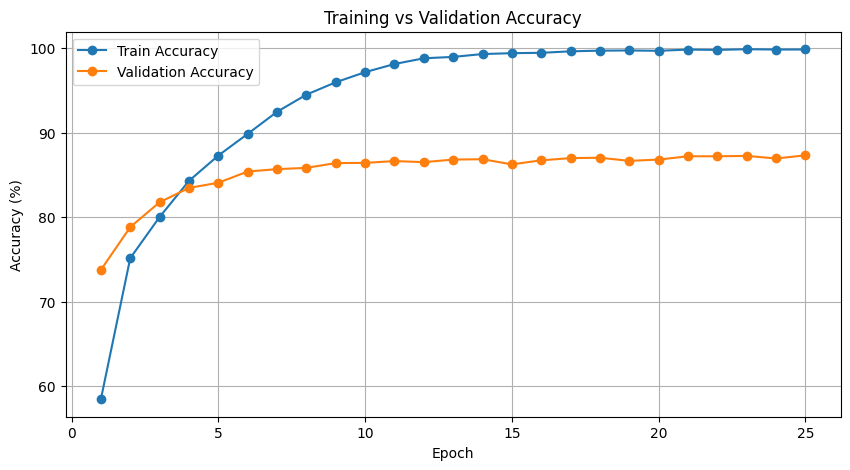

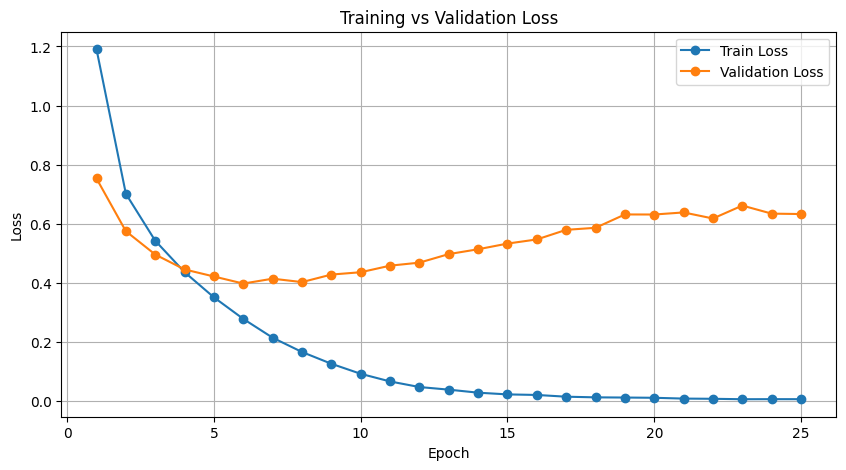

In [30]:
import matplotlib.pyplot as plt

# Load metrics from CSV
metrics_df = pd.read_csv("metrics_xception_ABC.csv")

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(metrics_df["Epoch"], metrics_df["Train Accuracy"], label="Train Accuracy", marker="o")
plt.plot(metrics_df["Epoch"], metrics_df["Val Accuracy"], label="Validation Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(metrics_df["Epoch"], metrics_df["Train Loss"], label="Train Loss", marker="o")
plt.plot(metrics_df["Epoch"], metrics_df["Val Loss"], label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

